# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [2]:
filename = 'ModSimPy/notebooks/data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [5]:
def get_first_label(series):
    """Get the first label of a pandas Series."""
    return series.index[0]
def get_last_label(series):
    """Get the first label of a pandas Series."""
    return series.index[-1]

def get_first_value(series):
    """Get the first value of a pandas Series."""
    return series.iloc[0]

def get_last_value(series):
    """Get the first value of a pandas Series."""
    return series.iloc[-1]

In [6]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [7]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

namespace(t_0=1950,
          t_end=2016,
          p_0=2.557628654,
          annual_growth=0.07224800083333333)

And we can encapsulate the code that runs the model in a function.

In [8]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [9]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plt.plot(census, ':', label='US Census')
    plt.plot(un, '--', label='UN DESA')
    plt.plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

In [10]:
import matplotlib.pyplot as plt

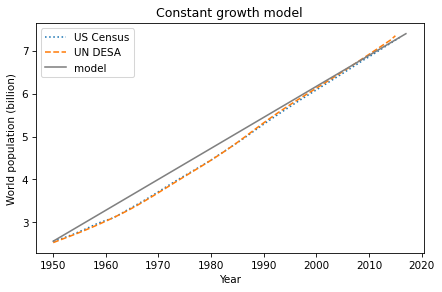

In [11]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [12]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [13]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file chap06-fig01.pdf


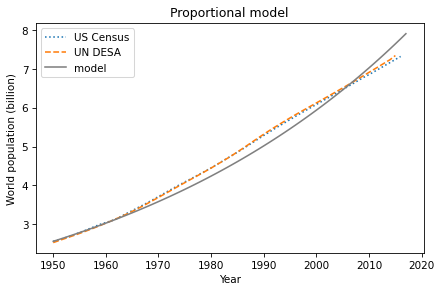

In [14]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [15]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [16]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [17]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [18]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [19]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

namespace(t_0=1950,
          t_end=2016,
          p_0=2.557628654,
          birth_rate=0.027,
          death_rate=0.01)

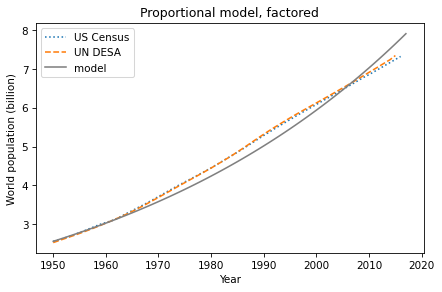

In [20]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

t:1950.0 and pop: 2.557628654
t:1951.0 and pop: 2.601108341118
t:1952.0 and pop: 2.645327182917006
t:1953.0 and pop: 2.6902977450265952
t:1954.0 and pop: 2.7360328066920476
t:1955.0 and pop: 2.7825453644058125
t:1956.0 and pop: 2.829848635600711
t:1957.0 and pop: 2.8779560624059233
t:1958.0 and pop: 2.926881315466824
t:1959.0 and pop: 2.9766382978297603
t:1960.0 and pop: 3.0272411488928666
t:1961.0 and pop: 3.078704248424045
t:1962.0 and pop: 3.131042220647254
t:1963.0 and pop: 3.184269938398258
t:1964.0 and pop: 3.2384025273510284
t:1965.0 and pop: 3.293455370315996
t:1966.0 and pop: 3.349444111611368
t:1967.0 and pop: 3.406384661508761
t:1968.0 and pop: 3.46429320075441
t:1969.0 and pop: 3.523186185167235
t:1970.0 and pop: 3.583080350315078
t:1971.0 and pop: 3.6439927162704344
t:1972.0 and pop: 3.7059405924470314
t:1973.0 and pop: 3.768941582518631
t:1974.0 and pop: 3.833013589421448
t:1975.0 and pop: 3.8981748204416125
t:1976.0 and pop: 3.9644437923891203
t:1977.0 and pop: 4.0318393

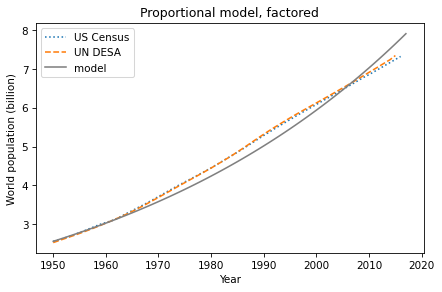

In [21]:
def update_func1(pop, t, system):
    print(f't:{t} and pop: {pop}')
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

def run_simulation(system, update_func):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    return results

results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')


### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [22]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

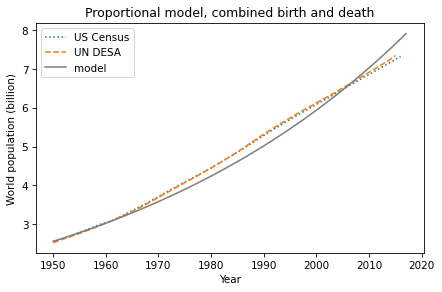

In [23]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [24]:
# Solution goes 
def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    alpha1: before 1980 growth rate
    alpha2: growth rate on or after 1980

    
    returns: population next year
    """
    if t< 1980:
        net_growth = system.alpha1  * pop
    else:
        net_growth = system.alpha2  * pop
    return pop + net_growth

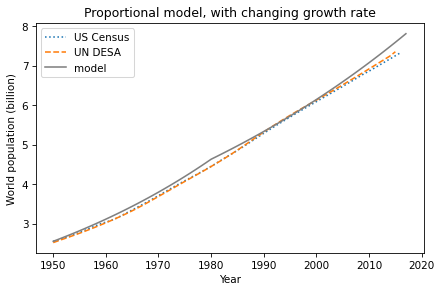

In [32]:
# Solution goes here
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha1=0.02,
                alpha2=0.0142)
results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, with changing growth rate')
